# SMM with Gradient Descent

## Python Imports

In [1]:
import numpy as np
import random
import copy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from argparse import ArgumentParser

## Arguments from command line

In [ ]:
'''
parser = ArgumentParser(description="SMM gradient descent")
parser.add_argument("-l", action="store", dest="LAMB", default=0.01, type=float, help="Lambda")
parser.add_argument("-t", action="store", dest="TRAINING_FILE", type=str, help="File with training data")
parser.add_argument("-e", action="store", dest="EVALUATION_FILE", type=str, help="File with evaluation data")
parser.add_argument("-epi", action="store", dest="EPSILON", default=0.05, type=float, help="Epsilon")
parser.add_argument("-s", action="store", dest="SEED", default=1, type=int, help="Seed for random numbers")
parser.add_argument("-i", action="store", dest="EPOCHS", default=100, type=int, help="Number of epochs to train")

args = parser.parse_args()
lamb = args.LAMB
training_file = args.TRAINING_FILE
evaluation_file = args.EVALUATION_FILE
epsilon = args.EPSILON
seed = args.SEED
epochs = args.EPOCHS
'''

## Data Imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [2]:
data_dir = "../../data/"

### Training Data

In [6]:
training_file = data_dir + "AllFiles/A0101/f000"
#training_file = data_dir + "SMM/A2403_training"

training = np.loadtxt(training_file, dtype=str)

### Evaluation Data

In [8]:
evaluation_file = data_dir + "AllFiles/A0201/c000"
#evaluation_file = data_dir + "SMM/A2403_evaluation"
evaluation = np.loadtxt(evaluation_file, dtype=str)

### Alphabet

In [9]:
alphabet_file = data_dir + "Matrices/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

### Sparse Encoding Scheme

In [10]:
sparse_file = data_dir + "Matrices/sparse"
_sparse = np.loadtxt(sparse_file, dtype=float)
sparse = {}

for i, letter_1 in enumerate(alphabet):
    
    sparse[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        sparse[letter_1][letter_2] = _sparse[i, j]

## Peptide Encoding

In [11]:
def encode(peptides, encoding_scheme, alphabet):
    
    encoded_peptides = []

    for peptide in peptides:

        encoded_peptide = []

        for peptide_letter in peptide:

            for alphabet_letter in alphabet:

                encoded_peptide.append(encoding_scheme[peptide_letter][alphabet_letter])

        encoded_peptides.append(encoded_peptide)
        
    return np.array(encoded_peptides)

## Error Function

In [12]:
def cumulative_error(peptides, y, lamb, weights):

    error = 0
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]

        # get target prediction value
        y_target = y[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
            
        # calculate error
        error += 1.0/2 * (y_pred - y_target)**2
        
    gerror = error + lamb*np.dot(weights, weights)
    error /= len(peptides)
        
    return gerror, error

## Predict value for a peptide list

In [13]:
def predict(peptides, weights):

    pred = []
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
        
        pred.append(y_pred)
        
    return pred

## Calculate MSE between two vectors

In [14]:
def cal_mse(vec1, vec2):
    
    mse = 0
    
    for i in range(0, len(vec1)):
        mse += (vec1[i] - vec2[i])**2
        
    mse /= len(vec1)
    
    return( mse)

## Gradient Descent

In [15]:
def gradient_descent(y_pred, y_target, peptide, weights, lamb_N, epsilon):
    
    # do is dE/dO
    do = (y_pred - y_target)    #XX
        
    for i in range(0, len(weights)):
        
        de_dw_i = do * peptide[i] + 2*lamb_N * weights[i]    #XX

        weights[i] -= epsilon * de_dw_i

## Main Loop



In [16]:
# Random seed 
np.random.seed(1)

# peptides
peptides = training[:, 0]
peptides = encode(peptides, sparse, alphabet)
N = len(peptides)

# target values
y = np.array(training[:, 1], dtype=float)

#evaluation peptides
evaluation_peptides = evaluation[:, 0]
evaluation_peptides = encode(evaluation_peptides, sparse, alphabet)

#evaluation targets
evaluation_targets = np.array(evaluation[:, 1], dtype=float)

# weights
input_dim  = len(peptides[0])
output_dim = 1
w_bound = 0.1
weights = np.random.uniform(-w_bound, w_bound, size=input_dim)

# training epochs
epochs = 100

# regularization lambda
lamb = 0.01
#lamb = 1
#lamb = 10

# regularization lambda per target value
lamb_N = lamb/N

# learning rate
epsilon = 0.01
#epsilon = 0.05

# error  plot
gerror_plot = []
mse_plot = []
train_mse_plot = []
eval_mse_plot = []
train_pcc_plot = []
eval_pcc_plot = []

# for each training epoch
for e in range(0, epochs):

    # for each peptide
    for i in range(0, N):

        # random index
        ix = np.random.randint(0, N)
        
        # get peptide       
        peptide = peptides[ix]

        # get target prediction value
        y_target = y[ix]
       
        # get initial prediction
        y_pred = np.dot(peptide, weights)

        # gradient descent 
        gradient_descent(y_pred, y_target, peptide, weights, lamb_N, epsilon)

    # compute error
    gerr, mse = cumulative_error(peptides, y, lamb, weights) 
    gerror_plot.append(gerr)
    mse_plot.append(mse)
    
    # predict on training data
    train_pred = predict( peptides, weights )
    train_mse = cal_mse( y, train_pred )
    train_mse_plot.append(train_mse)
    train_pcc = pearsonr( y, train_pred )
    train_pcc_plot.append( train_pcc[0] )
        
    # predict on evaluation data
    eval_pred = predict(evaluation_peptides, weights )
    eval_mse = cal_mse(evaluation_targets, eval_pred )
    eval_mse_plot.append(eval_mse)
    eval_pcc = pearsonr(evaluation_targets, eval_pred)
    eval_pcc_plot.append( eval_pcc[0] )
    
    print ("Epoch: ", e, "Gerr:", gerr, train_pcc[0], train_mse, eval_pcc[0], eval_mse)

Epoch:  0 Gerr: 11.477972780342881 0.5178164184769052 0.024807379210674066 -0.10340528554933476 0.16700836087183876
Epoch:  1 Gerr: 8.41846383836521 0.6182385887124802 0.018194641094135745 -0.05831865191526414 0.1603021082281397
Epoch:  2 Gerr: 7.215054100009592 0.6643375668576688 0.015593963435857224 -0.025399181446805003 0.15519161176184407
Epoch:  3 Gerr: 6.59820707865221 0.6977662409128804 0.014260623646227717 -0.04320200067828124 0.1575407059031501
Epoch:  4 Gerr: 6.376071721991855 0.7139787687194701 0.013780236914758034 -0.021266461244952968 0.15258684735782163
Epoch:  5 Gerr: 6.180349570778116 0.7198929367850135 0.013357332381159702 0.057582805904402325 0.14420731136487458
Epoch:  6 Gerr: 6.18295665418901 0.7272679811141534 0.0133625439497689 0.02307051580371713 0.1496859431221252
Epoch:  7 Gerr: 6.1165015423008695 0.7263916147190467 0.01321907389323943 0.03371727800556511 0.1494167104392346
Epoch:  8 Gerr: 6.070555080536675 0.7274259750758215 0.013119878512366909 0.030588037690

## Error Plot

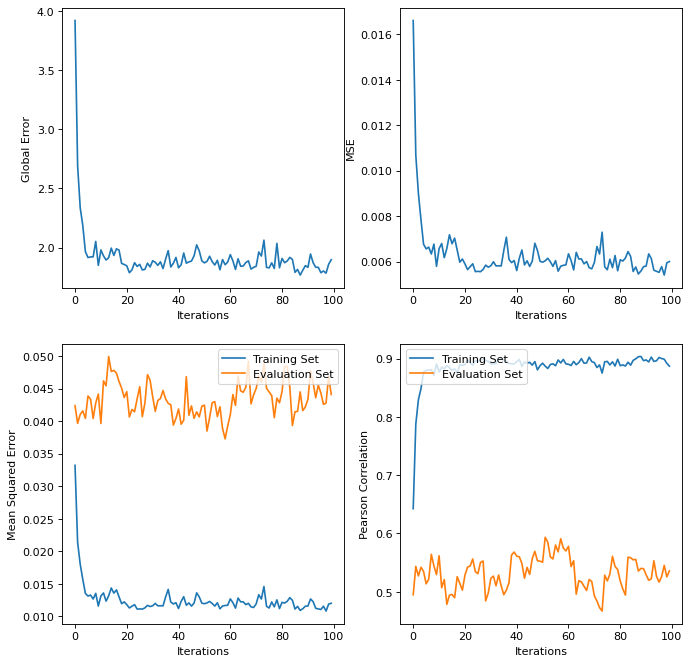

In [25]:
fig = plt.figure(figsize=(10, 10), dpi= 80)

x = np.arange(0, len(gerror_plot))

plt.subplot(2, 2, 1)
plt.plot(x, gerror_plot)
plt.ylabel("Global Error", fontsize=10);
plt.xlabel("Iterations", fontsize=10);

plt.subplot(2, 2, 2)
plt.plot(x, mse_plot)
plt.ylabel("MSE", fontsize=10);
plt.xlabel("Iterations", fontsize=10);


x = np.arange(0, len(train_mse_plot))

plt.subplot(2, 2, 3)
plt.plot(x, train_mse_plot, label="Training Set")
plt.plot(x, eval_mse_plot, label="Evaluation Set")
plt.ylabel("Mean Squared Error", fontsize=10);
plt.xlabel("Iterations", fontsize=10);
plt.legend(loc='upper right');


plt.subplot(2, 2, 4)
plt.plot(x, train_pcc_plot, label="Training Set")
plt.plot(x, eval_pcc_plot, label="Evaluation Set")
plt.ylabel("Pearson Correlation", fontsize=10);
plt.xlabel("Iterations", fontsize=10);
plt.legend(loc='upper left');

## Get PSSM Matrix

### Vector to Matrix

In [17]:
# our matrices are vectors of dictionaries
def vector_to_matrix(vector, alphabet):
    
    rows = int(len(vector)/len(alphabet))
    
    matrix = [0] * rows
    
    offset = 0
    
    for i in range(0, rows):
        
        matrix[i] = {}
        
        for j in range(0, 20):
            
            matrix[i][alphabet[j]] = vector[j+offset] 
        
        offset += len(alphabet)

    return matrix

### Matrix to Psi-Blast

In [18]:
def to_psi_blast(matrix):

    # print to user
    
    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 

### Print

In [19]:
matrix = vector_to_matrix(weights, alphabet)
to_psi_blast(matrix)

            A        R        N        D        C        Q        E        G        H        I        L        K        M        F        P        S        T        W        Y        V
 1 A  -0.0055  -0.0209  -0.0061  -0.0407   0.0259  -0.0418  -0.0009  -0.0353  -0.0253  -0.0419  -0.0001  -0.0642   0.0147  -0.0131  -0.0348  -0.0089  -0.0204  -0.0129   0.0408  -0.0379
 2 A   0.0835   0.0218  -0.0905  -0.0877   -0.005  -0.0172  -0.0145  -0.0371  -0.0089   0.0813   0.0574  -0.0516   0.0549  -0.0277   0.0264   0.1442   0.1533    0.027   0.0224   0.0599
 3 A   0.0342  -0.0046   0.0236   0.1122   0.0266  -0.0143   0.0246  -0.0419   -0.039  -0.0161  -0.0283  -0.0594    0.011  -0.0247  -0.0175   0.0359  -0.0437   0.0005  -0.0025   -0.039
 4 A  -0.0085   0.0205   0.0004   0.0229   0.0335   0.0326  -0.0083   0.0197   0.0173  -0.0168  -0.0035    0.021   0.0191  -0.0143  -0.0001   0.0129   0.0515  -0.0003   0.0148   0.0203
 5 A   0.0472   0.0306   0.0134  -0.0034  -0.0183   0.0495   0.0016   0.014

## Performance Evaluation

In [20]:
evaluation_peptides = evaluation[:, 0]
evaluation_peptides = np.array(encode(evaluation_peptides, sparse, alphabet))

evaluation_targets = np.array(evaluation[:, 1], dtype=float)

y_pred = []
for i in range(0, len(evaluation_peptides)):
    y_pred.append(np.dot(evaluation_peptides[i].T, weights))

y_pred = np.array(y_pred)

PCC:  0.04342352413700515


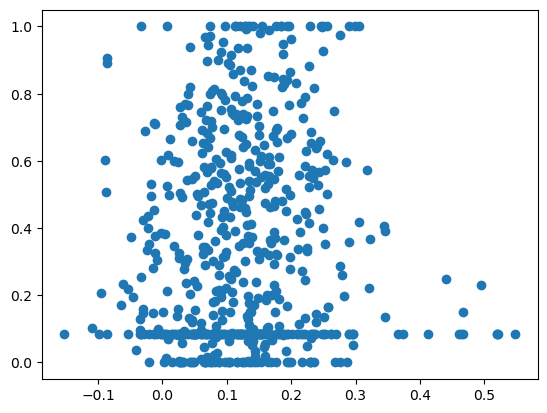

In [21]:
pcc = pearsonr(evaluation_targets, np.array(y_pred))
print("PCC: ", pcc[0])

plt.scatter(y_pred, evaluation_targets);